# Convolution用法

In [5]:
threshold_image.shape[1]

28

In [3]:
raw_image= cv2.imread('test_img.jpg',0)
_, threshold_image = cv2.threshold(raw_image, 0, 255,  cv2.THRESH_OTSU)

threshold_image= threshold_image.astype('float32')

x_img = tf.reshape(tf.threshold_image, [-1, threshold_image[0], threshold_image.shape[1,1]])

Tensor("Reshape_3:0", shape=(3, 3, 1, 1), dtype=float32)


Tensor("Reshape_11:0", shape=(3, 3, 1, 1), dtype=float32)


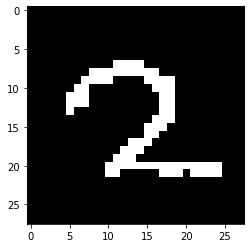

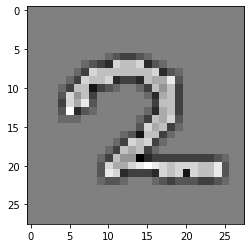

In [10]:
%matplotlib inline
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

temp = np.array([ [-1, -1, -1],
                  [-1,  8, -1],
                  [-1, -1, -1] ], dtype='float32')

# change kernel to 4D tensor
kernel = tf.reshape(tf.Variable(temp), [3, 3, 1, 1])   # 濾波器, 3 x 3 x 1(Kernel) , 1 張(因此此為黑白, 所以為1)
print(kernel) 

raw_image = cv2.imread('test_img.jpg', 0)   #讀為灰階圖像
_, threshold_image = cv2.threshold(raw_image, 0, 255, cv2.THRESH_OTSU)  # 黑白照片, 以0當threshold, 值>0,當255

threshold_image= threshold_image.astype('float32')

# change image to 4D tensor
x_img = tf.reshape(threshold_image, [-1, threshold_image.shape[0], threshold_image.shape[1], 1])   
                                    #-1地方為批次大小, 但此處我們沒有批次, 所以給-1，函式會當成1
    
y_conv = tf.nn.conv2d(x_img, kernel, strides=[1, 1, 1, 1], padding='SAME')  
# conv2d(輸入的照片(但為4D tensor),濾波器(4D tensor),每一維的步數 第2個1, 是X步長, 第3個1是y步長1,第1跟最後不會用到, 但沒解釋 
with tf.Session() as sess:
    sess.run( tf.global_variables_initializer() )
    result = sess.run(y_conv)
    
    result_img = np.reshape(result, [threshold_image.shape[0], threshold_image.shape[1]])
    #因為要畫出來所以要還原為3D
    plt.imshow(threshold_image, cmap='gray')
    plt.show()
    
    plt.imshow(result_img, cmap='gray')
    plt.show()

# Maxpooling用法 

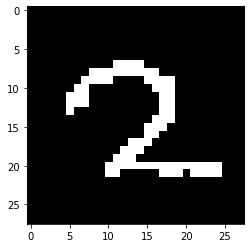

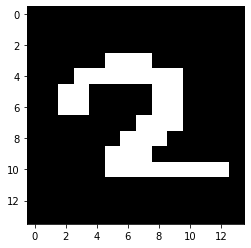

In [11]:
%matplotlib inline
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


raw_image = cv2.imread('test_img.jpg', 0)
_, threshold_image = cv2.threshold(raw_image, 0, 255, cv2.THRESH_OTSU)

threshold_image= threshold_image.astype('float32')

# change image to 4D tensor
x_img = tf.reshape(threshold_image, [-1, threshold_image.shape[0], threshold_image.shape[1], 1])

# ksize = [1, width, height, 1]
# strides = [1, horizontal strides, vertical strides, 1] [2,2] in this code
y_maxpool = tf.nn.max_pool(x_img, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')  
                                #Kernel濾波器大小為2*2, strides這邊步長設為2
with tf.Session() as sess:
    sess.run( tf.global_variables_initializer() )
    result = sess.run(y_maxpool)
    
    result_img = np.reshape(result, [14, 14])   
    
    plt.imshow(threshold_image, cmap='gray')
    plt.show()
    
    plt.imshow(result_img, cmap='gray')
    plt.show()

# 建構CNN神經網路

In [12]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

def weight_variable(shape):  # 初始化 W
    initial_value = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial_value)

def bias_variable(shape):    # 初始化 b
    initial_value = tf.constant(0.1, shape=shape)
    return tf.Variable(initial_value)

def conv2d(x, W):   #x為照片, W 為濾波器, Kernel, 一定要為4D tensor
    # strides = [1, horizontal strides, vertical strides, 1], padding = SAME mean add paddings on input data
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    # ksize = [1, width, height, 1]
    # strides = [1, horizontal strides, vertical strides, 1]
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

W_conv1 = weight_variable([5, 5, 1, 32])      # 此處將kernel設為5*5 1為黑白, 32 張照片
b_conv1 = bias_variable([32])

x = tf.placeholder(tf.float32, [None, 784])
y_ = tf.placeholder(tf.float32, [None, 10])

# Reshape our data as 4-D tensorflow. Remind that a batch of images is a 4-D tensor
x_image = tf.reshape(x, [-1, 28, 28, 1]) #  -1為批次因只有一張圖, 讓程式先忽略, 因CNN不須要將照片拉平, 所以於此處還原照片
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)  #己經用卷積+激活函數
h_pool1 = max_pool_2x2(h_conv1)


W_conv2 = weight_variable([5, 5, 32, 64])    #32 於此不能變動, 其餘可變, 5,5 為濾波器大小,掌管權重,64 可更動
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

W_fc1 = weight_variable([7 * 7 * 64, 1024])  
b_fc1 = bias_variable([1024])

# Flatten previous layer result and feed them into fully connected layer  此處開始為DNN, 所以拉成一維向量
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

# Define cost
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))

# Optimization 
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

# Calculate accuracy 
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(1000):
        batch = mnist.train.next_batch(100)
        
        train_step_ = sess.run(train_step, feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})
        if i % 100 == 0:
            train_accuracy = sess.run(accuracy, feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})
            print('step {}, training accuracy {}'.format(i, train_accuracy))
            
    test_accuracy_ = sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0})    
    print('test accuracy {}'.format(test_accuracy_))

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v